In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

import xml.etree.ElementTree as ET


TICK_TOCK = 'TickTock'
IRIS = 'IRIS'
JOCKER = 'Joker'

TICK_TOCK_PATH = 'data/TickTock.xml'
IRIS_PATH = 'data/IRIS.xml'
JOCKER_PATH = 'data/Joker.xml'

In [2]:
def load_preproces_data(PATH) :
    '''
    return df with X and Y
    
    '''
    tree  = ET.parse(PATH)
    root = tree.getroot()

    BOT_TAG = 'SYSTEM'
    Y = []
    X = []

    for dialog_indx,dialog in enumerate(root) :

        is_user1_bot = dialog[3][0].text == BOT_TAG
        is_user2_bot = dialog[4][0].text == BOT_TAG

        yi = [int(is_user1_bot),int(is_user2_bot)]
        Y.append(yi)

        for child in dialog :
            if child.tag == 'turn' :
                #print('user_type :',child[0].text)

                #в рамках данного датасета кто-то из говорящих точно бот
                is_speeker_bot = child[0].text == BOT_TAG

                is_user1 = (is_speeker_bot and is_user1_bot) or (not(is_speeker_bot) and is_user2_bot)
                is_user2 = not is_user1 #если говорит 1й то значит второй молчит

                xi = [dialog_indx,int(is_user1),int(is_user2),child[1].text]
                X.append(xi)

    Y = np.array(Y)
    X = np.array(X)
    
    df = pd.DataFrame(columns=['dialog_indx','is_user1','is_user2','text','embeding'])
    df['dialog_indx'] = X[:,0] 
    df['is_user1'] = X[:,1]
    df['is_user2'] = X[:,2]
    df['text'] = X[:,3]

    df['dialog_indx'] = df['dialog_indx'].apply(pd.to_numeric)
    df['is_user1'] = df['is_user1'].apply(pd.to_numeric)
    df['is_user2'] = df['is_user2'].apply(pd.to_numeric)
    
    return df,Y

In [3]:
df,Y = load_preproces_data(JOCKER_PATH)

In [4]:
df.head()

,dialog_indx,is_user1,is_user2,text,embeding
0,0,1,0,hello,NaN
1,0,0,1,hello,NaN
2,0,1,0,i'm USER_NAME,NaN
3,0,0,1,what dent,NaN
4,0,1,0,who are you?,NaN


In [8]:
#провека на каличность auc_roc
#for dialog in root :
#    print(dialog[3][0].text,dialog[4][0].text)

# Получим статистики по датасету

статистики :
0. количество пустых реплик
1. количество пустых диалогов 
2. количество монологов

распределение :
 1. длина диалгоа (в ко-во фраз)
 2. количество слов в диалоге
 3. количество символов в диалоге


In [5]:
def get_pharaze_statistics(df) :
    '''
    return 
        dilalog_len = []     #длина диалгоа (в ко-во фраз)
        dialog_cnt_word = []   #количество слов в диалоге
        conversation_cnt_chr = []    #количество символов в диалоге
    '''
    
    dilalog_len = []
    for indx in np.unique(df['dialog_indx'].values) :
        dilalog_len.append(df.loc[df['dialog_indx'] == indx]['text'].values.shape[0])
        
    dialog_cnt_word = []
    for indx in np.unique(df['dialog_indx'].values) :
        dialog_cnt_word.append(len(' '.join(df.loc[df['dialog_indx'] == indx]['text'].values).split(' ')))
        
    dialog_cnt_char =[]
    for indx in np.unique(df['dialog_indx'].values) :
        dialog_cnt_char.append(len(' '.join(df.loc[df['dialog_indx'] == indx]['text'].values)))
        
    return dilalog_len,dialog_cnt_word,dialog_cnt_char

Количество пустых реплик == 0 поскольку минимальная длинна реплики =  1
Количесвто пустых диалогов == 0 поскольку :
Минимальная длина диалога (в кол-во фраз) : 6 максимальная : 180
percentile 5%-95% :  [11.1 77.8]


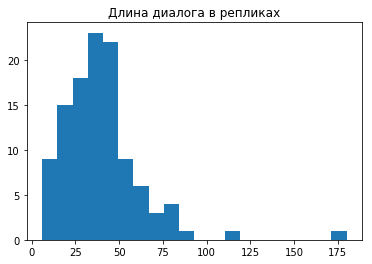

Минимальное количесвто фраз в диалоге : 11


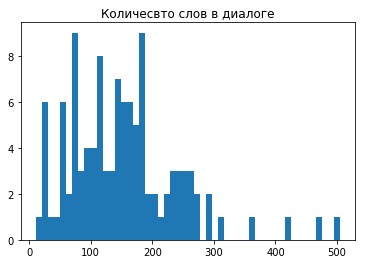

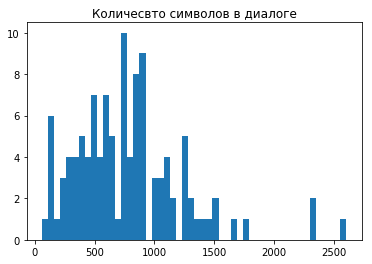

Количество монологов == 0 посколько следующий код исполняется без ощшибки


In [6]:
dilalog_len,dialog_cnt_word,dialog_cnt_char = get_pharaze_statistics(df)

print('Количество пустых реплик == 0 поскольку минимальная длинна реплики = ',min([len(thread) for thread in df.text.values]))

print('Количесвто пустых диалогов == 0 поскольку :')
print('Минимальная длина диалога (в кол-во фраз) :',min(dilalog_len),'максимальная :',max(dilalog_len))
print('percentile 5%-95% : ',np.percentile(dilalog_len, [5,95]))

plt.hist(dilalog_len,bins=20)
plt.title('Длина диалога в репликах')
plt.show()

print('Минимальное количесвто фраз в диалоге :',min(dialog_cnt_word))
plt.title('Количесвто слов в диалоге')
plt.hist(dialog_cnt_word,bins=50)
plt.show()
    
plt.title('Количесвто символов в диалоге')
plt.hist(dialog_cnt_char,bins=50)
plt.show()


print('Количество монологов == 0 посколько следующий код исполняется без ощшибки')
for indx in np.unique(df['dialog_indx'].values) :
    user1_thread_cnt = df.loc[df['dialog_indx'] == indx]['is_user1'].values.sum()
    user2_thread_cnt = df.loc[df['dialog_indx'] == indx]['is_user2'].values.sum()
    
    assert user1_thread_cnt != 0
    assert user2_thread_cnt != 0

# Получим обобщённую статистику для всех датасетов

In [7]:
for name,path in [(TICK_TOCK,TICK_TOCK_PATH),(IRIS,IRIS_PATH),(JOCKER,JOCKER_PATH)] :
    df,Y = load_preproces_data(path)
    dilalog_len,dialog_cnt_word,dialog_cnt_char = get_pharaze_statistics(df)
    dcnt = np.unique(df.dialog_indx.values).shape[0]
    
    
    print('Info for %s' % name)
    print('Dialog count : %s' % dcnt)
    print('Average phraze in dialogue  : %s' % np.average(dilalog_len))
    print('Average count of word in dialogue : %s' % np.average(dialog_cnt_word))
    print('Average count of char in dialogue : %s' % np.average(dialog_cnt_char))
    print()

Info for TickTock
Dialog count : 206
Average phraze in dialogue  : 26.514563106796118
Average count of word in dialogue : 189.04854368932038
Average count of char in dialogue : 983.1019417475728

Info for IRIS
Dialog count : 163
Average phraze in dialogue  : 34.88957055214724
Average count of word in dialogue : 182.68711656441718
Average count of char in dialogue : 960.5582822085889

Info for Joker
Dialog count : 112
Average phraze in dialogue  : 39.982142857142854
Average count of word in dialogue : 154.23214285714286
Average count of char in dialogue : 776.5892857142857



In [11]:
matplotlib.rcParams.update({'font.size': 22})

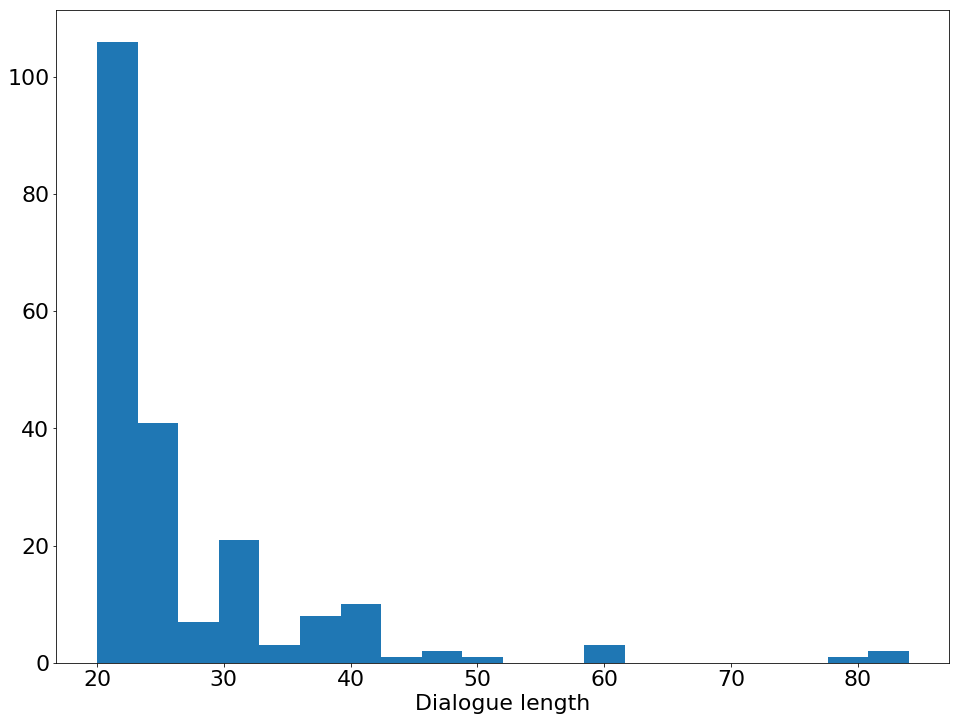

In [12]:
df,Y = load_preproces_data(TICK_TOCK_PATH)
dilalog_len,dialog_cnt_word,dialog_cnt_char = get_pharaze_statistics(df)

plt.figure(figsize=(16,12))
plt.hist(dilalog_len,bins=20)
plt.xlabel('Dialogue length')

plt.show()

### Вывод : данные относительно чистые, будем использовать их целиком

# Преобразуем embedigs

In [104]:
import torch

GLOVE_PATH = 'InferSent/glove.840B.300d.txt'
INFERSENT_MODEL_PATH = 'InferSent/infersent.allnli.pickle'

In [105]:
model_inferSent = torch.load(INFERSENT_MODEL_PATH, map_location=lambda storage, loc: storage)
torch.set_num_threads(5)

model_inferSent.set_glove_path(GLOVE_PATH)
model_inferSent.build_vocab_k_words(K=100000)

C:\Users\frizman04\Anaconda3\lib\site-packages\torch\serialization.py:325: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\frizman04\Anaconda3\lib\site-packages\torch\serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Vocab size : 100000


In [106]:
%%time
embedings = model_inferSent.encode(df['text'].values, bsize=128, tokenize=False, verbose=True)

Nb words kept : 41839/49769 (84.07 %)
Speed : 36.17 sentences/s (cpu mode, bsize=128)
Wall time: 2min 31s


In [107]:
for indx,embd in enumerate(embedings) :
    df.at[indx,'embeding'] = embd

In [108]:
df.head()

,dialog_indx,is_user1,is_user2,text,embeding
0,0,1,0,Hi,"[-0.018926175, -0.084827036, -0.030445112, -0...."
1,0,0,1,"We never really grow up, we only learn how to ...","[0.095699556, 0.03992436, 0.0041139815, -0.007..."
2,0,1,0,How old are you,"[0.03790433, -0.03920184, -0.00667746, 0.01039..."
3,0,0,1,"Uh-huh, I do. What do you think?","[0.0137795145, -0.053905495, -0.027774377, -0...."
4,0,1,0,Are you a robot?,"[0.04048376, 0.0039107967, -0.022042304, -0.06..."


In [109]:
MAX_DIALOG_LENGTH = 180#max(dilalog_len)
COUNT_OF_DIALOG = df['dialog_indx'].max() + 1
EMPTY_INFERSENT_VECT = np.zeros(shape=4096) #model_inferSent.encode([''])[0]

print('Max dialog len : %s' % MAX_DIALOG_LENGTH)
print('Cnt of dialog : %s ' % COUNT_OF_DIALOG)

Max dialog len : 180
Cnt of dialog : 206 


In [110]:
%%time

X = []
EMPTY_INFERSENT_VECT_with_user1or2 = np.hstack(([0,0],EMPTY_INFERSENT_VECT))

for indx in range(COUNT_OF_DIALOG) :
    
    curr_dialog_embeding = list(df.loc[df['dialog_indx'] == indx]['embeding'].values)
    curr_dialog_user1or2 = df.loc[df['dialog_indx'] == indx][['is_user1','is_user2']].values

    curr_dialog = []
    for embeding,user1or2 in zip(curr_dialog_embeding,curr_dialog_user1or2) :
        curr_dialog.append(np.hstack((user1or2,embeding)))
    
    while len(curr_dialog) < MAX_DIALOG_LENGTH :
        curr_dialog.append(EMPTY_INFERSENT_VECT_with_user1or2)
    curr_dialog = np.array(curr_dialog)
    X.append(curr_dialog)
    
X = np.array(X)

Wall time: 4.07 s


In [111]:
print('X shape %s ' % str(X.shape))
print('Y shape %s ' % str(Y.shape))

X shape (206, 180, 4098) 
Y shape (206, 2) 


In [112]:
np.save(open('tmp/X_TikTok_with_user_marker_empty0','wb'),X)
np.save(open('tmp/Y_TikTok','wb'),Y)

In [ ]:
#X = np.load(open('tmp/X_TikTok_with_user_marker_empty0','rb'))
#Y = np.load(open('tmp/Y_TikTok','rb'))

# Обьеденим датасеты

In [3]:
X_TikTok_PATH = 'tmp/X_TikTok_with_user_marker_empty0'
X_JOKER_PATH = 'tmp/X_JOKER_with_user_marker_empty0'
X_IRIS_PATH = 'tmp/X_IRIS_with_user_marker_empty0'

Y_TikTok_PATH = 'tmp/Y_TikTok'
Y_JOKER_PATH = 'tmp/Y_JOKER'
Y_IRIS_PATH = 'tmp/Y_IRIS'

In [4]:
X_TikTok = np.load(open(X_TikTok_PATH,'rb'))
X_JOKER = np.load(open(X_JOKER_PATH,'rb'))
X_IRIS = np.load(open(X_IRIS_PATH,'rb'))
Y_TikTok = np.load(open(Y_TikTok_PATH,'rb'))
Y_JOKER = np.load(open(Y_JOKER_PATH,'rb'))
Y_IRIS = np.load(open(Y_IRIS_PATH,'rb'))

In [5]:
print(X_TikTok.shape)
print(X_JOKER.shape)
print(X_IRIS.shape)

(206, 180, 4098)
(112, 180, 4098)
(163, 180, 4098)


In [6]:
X_xml = np.concatenate((X_TikTok,X_JOKER,X_IRIS),axis=0)

In [8]:
Y_xml = np.concatenate((Y_TikTok,Y_JOKER,Y_IRIS),axis=0)
print(Y_xml.shape)

(481, 2)


In [10]:
np.save(open('tmp/X_TikTok_JOKER_IRIS_chatbot','wb'),X_xml)
np.save(open('tmp/Y_TikTok_JOKER_IRIS_chatbot','wb'),Y_xml)